# Phase 2: Trajectory Prediction with Auxiliary Depth Estimation

# 🧭 Introduction

"""
Welcome to **Phase 2** of the DLAV Projec! 🚗💨

In this phase, you'll work with a more challenging dataset that includes:
- RGB **camera images**
- Ground-truth **depth maps**
- Ground-truth **semantic segmentation** labels

Your goal is still to predict the **future trajectory** of the self-driving car (SDC), but you now have more tools at your disposal! 🎯

Here, we provide an example where **depth estimation** is used as an auxiliary task to improve trajectory prediction.

However, you're **free to explore** other auxiliary tasks (e.g., using semantic labels), different loss functions, data augmentations, or better architectures! 💡

This notebook will walk you through loading the dataset, building a model, training with and without the auxiliary task, and visualizing results.
"""

In [75]:
# Install gdown to handle Google Drive file download
!pip install -q gdown
import os
import gdown
import zipfile


output_dir = os.path.join("data", "phase2")
if not os.path.exists(output_dir):  # Check if the directory already exists
    os.makedirs(output_dir)  # Create the directory if it doesn't exist

# Download the train dataset
download_url = f"https://drive.google.com/uc?id=1YkGwaxBKNiYL2nq--cB6WMmYGzRmRKVr"
output_zip = os.path.join(output_dir, "dlav_train.zip")

if not os.path.exists(output_zip):  # Check if the file already exists
    gdown.download(download_url, output_zip, quiet=False)  # Downloads the file to your drive
if not os.path.exists(os.path.join(output_dir, "train")):  # Check if the directory already exists    
    with zipfile.ZipFile(output_zip, 'r') as zip_ref:  # Extracts the downloaded zip file
        zip_ref.extractall(output_dir)

# Download the validation dataset
download_url = "https://drive.google.com/uc?id=1wtmT_vH9mMUNOwrNOMFP6WFw6e8rbOdu"
output_zip = os.path.join(output_dir, "dlav_val.zip")

if not os.path.exists(output_zip):  # Check if the file already exists
    gdown.download(download_url, output_zip, quiet=False)  # Downloads the file to your drive
if not os.path.exists(os.path.join(output_dir, "val")):  # Check if the directory already exists
    with zipfile.ZipFile(output_zip, 'r') as zip_ref:  # Extracts the downloaded zip file
        zip_ref.extractall(output_dir)

# Download the test dataset
download_url = "https://drive.google.com/uc?id=1G9xGE7s-Ikvvc2-LZTUyuzhWAlNdLTLV"
output_zip = os.path.join(output_dir, "dlav_test_public.zip")

if not os.path.exists(output_zip):  # Check if the file already exists
    gdown.download(download_url, output_zip, quiet=False)  # Downloads the file to your drive
if not os.path.exists(os.path.join(output_dir, "test_public")):  # Check if the directory already exists
    with zipfile.ZipFile(output_zip, 'r') as zip_ref:  # Extracts the downloaded zip file
        zip_ref.extractall(output_dir)

## 📂 The Dataset

We are now working with a richer dataset that includes not just images and trajectories,
but also **depth maps** (and semantic segmentation labels, though unused in this example).

The data is stored in `.pkl` files and each file contains:
- `camera`: RGB image (shape: H x W x 3)
- `sdc_history_feature`: the past trajectory of the car
- `sdc_future_feature`: the future trajectory to predict
- `depth`: ground truth depth map (shape: H x W x 1)

We'll define a `DrivingDataset` class to load and return these tensors in a format our model can work with.

In [77]:
import os
import torch
import pickle
import numpy as np
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
import csv
import random
seed = 13
torch.manual_seed(seed)
np.random.seed(seed)
random.seed(seed)

class DrivingDataset(Dataset):
    def __init__(self, file_list, test=False):
        self.samples = file_list
        self.test = test

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        with open(self.samples[idx], 'rb') as f:
            data = pickle.load(f)

        camera = torch.FloatTensor(data['camera']).permute(2, 0, 1) / 255.0
        history = torch.FloatTensor(data['sdc_history_feature'])

        depth = torch.FloatTensor(data['depth'])
        semantic = torch.FloatTensor(data['semantic_label'])
        if not self.test:
            future = torch.FloatTensor(data['sdc_future_feature'])
            return {
                'camera': camera,
                'history': history,
                'depth': depth,
                'future': future,
                'semantic': semantic
            }
        else:
            return {
                'camera': camera,
                'history': history,
                'depth': depth,
                'semantic': semantic
            }

In [78]:
train_dataset = DrivingDataset(
    [os.path.join("data", "phase2", "train", f) for f in os.listdir(os.path.join("data", "phase2", "train")) if f.endswith('.pkl')]
)
train_dataset[0]['camera'].shape, train_dataset[0]['history'].shape, train_dataset[0]['depth'].shape,  train_dataset[0]['semantic'].shape

(torch.Size([3, 200, 300]),
 torch.Size([21, 3]),
 torch.Size([200, 300, 1]),
 torch.Size([200, 300]))

## Data Augmentation

In [79]:
import os
import random
import matplotlib.pyplot as plt
import pickle
import numpy as np
from tqdm import tqdm

def augment_and_save(file_list, save_dir):
    os.makedirs(save_dir, exist_ok=True)
    new_files = []

    for file_path in tqdm(file_list):
        with open(file_path, 'rb') as f:
            data = pickle.load(f)

        # Flip image horizontally
        camera = data['camera'][:, ::-1, :]  # shape HxWxC, flip width
        depth = data['depth'][:, ::-1, :]
        semantic = data['semantic_label'][:, ::-1]
        # Flip signs for 2nd and 3rd cols in history and future
        data['camera'] = camera
        data['depth'] = depth
        data['sdc_history_feature'][:, 1:] *= -1
        data['semantic_label'] = semantic

        if 'sdc_future_feature' in data:
            data['sdc_future_feature'][:, 1:] *= -1

        

        # Save to new file
        base = os.path.basename(file_path)
        new_path = os.path.join(save_dir, f"flipped_{base}")
        with open(new_path, 'wb') as f:
            pickle.dump(data, f)

        new_files.append(new_path)

    return new_files

augmented_train_path = os.path.join("data", "phase2", "augmented_train")
if not os.path.exists(augmented_train_path):
    train_data_dir = os.path.join("data", "phase2", "train")
    train_files = [os.path.join(train_data_dir, f) for f in os.listdir(train_data_dir) if f.endswith('.pkl')]
    augmented_train = augment_and_save(train_files, save_dir=augmented_train_path)
else:
    print("Augmented training data already exists. Skipping augmentation.")

val_train_path = os.path.join("data", "phase2", "augmented_val")
if not os.path.exists(val_train_path):
    val_data_dir = os.path.join("data", "phase2", "val")
    val_files = [os.path.join(val_data_dir, f) for f in os.listdir(val_data_dir) if f.endswith('.pkl')]
    augmented_val = augment_and_save(val_files, save_dir=val_train_path)
else:
    print("Augmented validation data already exists. Skipping augmentation.")

Augmented training data already exists. Skipping augmentation.
Augmented validation data already exists. Skipping augmentation.


## 🧠 The Model: Trajectory + Depth Prediction

We've extended our trajectory prediction model to optionally include a **depth estimation decoder**.

Why?
- Predicting depth helps the model **learn richer visual features** from the camera input.
- This acts as a form of **multi-task learning**, where learning to estimate depth reinforces scene understanding, ultimately leading to better trajectory predictions.
- This can be especially useful in complex environments with occlusions or sharp turns.

The model has:
- A CNN backbone to extract features from the image
- An MLP to process historical trajectory features
- A trajectory decoder to predict future coordinates
- (Optionally) A depth decoder to predict dense depth maps

This auxiliary task is enabled by setting `use_depth_aux=True`.

## Planners

In [80]:
import torch
import torch.nn as nn
import torchvision.models as models
import torch.nn.functional as F
import torch.optim as optim
import torchvision.models as models
import pytorch_lightning as pl
import os
from pytorch_lightning.loggers import TensorBoardLogger
from torch.utils.data import DataLoader
from torch.optim.lr_scheduler import ReduceLROnPlateau
from pytorch_lightning.callbacks import LearningRateMonitor
from pytorch_lightning.callbacks import ModelCheckpoint
from pytorch_lightning import seed_everything


class SharedEncoder(nn.Module):
    def __init__(self):
        super().__init__()
        resnet = models.resnet18(weights=True)
        self.encoder = nn.Sequential(*list(resnet.children())[:-2])  # (B, 512, H/32, W/32)
        self.visual_pool = nn.AdaptiveAvgPool2d((1, 1))  # For global features
        
        # Add a proper feature reduction layer for the decoders
        self.feature_reduction = nn.Conv2d(512, 256, kernel_size=1)
        self.visual_fc = nn.Linear(512, 256)  # For trajectory prediction

    def forward(self, x):
        feat_map = self.encoder(x)  # (B, 512, H, W)
        
        # Process feature map for decoders
        reduced_feat_map = self.feature_reduction(feat_map)  # (B, 256, H, W)  # added this
        
        # Global features for trajectory prediction
        pooled = self.visual_pool(feat_map).view(x.size(0), -1)  # (B, 512)
        pooled = self.visual_fc(pooled)  # (B, 256)
        
        return reduced_feat_map, pooled

    
class SemanticDecoder(nn.Module):
    def __init__(self, in_channels=256, num_classes=14, output_size=(200, 300)):
        super().__init__()
        self.output_size = output_size
        self.upsample = nn.Sequential(
            nn.Conv2d(in_channels, 128, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Upsample(scale_factor=2),
            nn.Conv2d(128, 64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Upsample(scale_factor=2),
            nn.Conv2d(64, num_classes, kernel_size=3, padding=1)  # → (B, 14, H, W)
        )

    def forward(self, x):
        x = self.upsample(x)
        return F.interpolate(x, size=self.output_size, mode='bilinear', align_corners=False)

class DepthDecoder(nn.Module):
    def __init__(self, in_channels=256, output_size=(200, 300)):
        super().__init__()
        self.output_size = output_size
        self.upsample = nn.Sequential(
            nn.Conv2d(in_channels, 128, 3, padding=1),
            nn.ReLU(),
            nn.Upsample(scale_factor=2),
            nn.Conv2d(128, 64, 3, padding=1),
            nn.ReLU(),
            nn.Conv2d(64, 1, 3, padding=1)
        )
    def forward(self, x):
        # Initial upsampling through the network
        x = self.upsample(x)  
        # Final resize to match ground truth dimensions
        return F.interpolate(x, size=self.output_size, mode='bilinear', align_corners=False)


class HistoryEncoder(nn.Module):
    def __init__(self, seq_len=21, feat_dim=2, hidden_dim=128): # changed the dimenstion to 2 instead of 3
        super().__init__()
        self.seq_len = seq_len
        self.feat_dim = feat_dim
        
        self.fc = nn.Sequential(
            nn.Linear(seq_len * feat_dim, 256),
            nn.ReLU(),
            nn.Linear(256, hidden_dim),
            nn.ReLU()
        )

    def forward(self, history):
        # history: B x T x 2
        batch_size = history.size(0)
        # Flatten the temporal dimension
        history_flat = history.reshape(batch_size, -1)  # B x (T*3)
        return self.fc(history_flat)  # B x hidden_dim


class MultiModalMultiTaskModel(nn.Module):
    def __init__(self, num_modes=6, pred_len=60, hist_seq_len=21, hist_feat_dim=2, depth_output_size=(200, 300)):
        super().__init__()
        self.num_modes = num_modes
        self.pred_len = pred_len
        
        # Visual encoder
        self.image_encoder = SharedEncoder()
        self.depth_decoder = DepthDecoder(in_channels=256, output_size=depth_output_size)
        self.semantic_decoder = SemanticDecoder(in_channels=256, num_classes=14, output_size=depth_output_size)
        # History encoder
        self.hist_encoder = HistoryEncoder(seq_len=hist_seq_len, feat_dim=hist_feat_dim, hidden_dim=128)
        
        # Fusion layer with batch normlization
        self.fusion = nn.Sequential(
            nn.Linear(256 + 128, 512),
            nn.BatchNorm1d(512),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(512, 512),
            nn.BatchNorm1d(512),
            nn.ReLU(),
            nn.Dropout(0.2)
        )
        
        # Trajectory decoder - predict multiple modes
        self.traj_decoder = nn.Linear(512, num_modes * pred_len * 2)  # Predict x,y coordinates for each mode
        
        # Confidence scores for each mode
        self.confidence_decoder = nn.Linear(512, num_modes)

    def forward(self, img, hist):
        # Encode image
        img_feat_map, img_feat_vector = self.image_encoder(img)

        # Task-specific predictions
        depth_pred = self.depth_decoder(img_feat_map)
        semantic_pred_logits = self.semantic_decoder(img_feat_map)

        # Encode history
        hist_feat = self.hist_encoder(hist)
        
        # Combine image and history features
        combined = torch.cat([img_feat_vector, hist_feat], dim=1)
        
        # Fusion layer
        fused = self.fusion(combined)
        
        # Decode trajectories and confidence scores
        traj_pred = self.traj_decoder(fused)
        traj_pred = traj_pred.view(-1, self.num_modes, self.pred_len, 2)  # B x M x T x 2
        
        # Predict confidence scores
        conf_pred = self.confidence_decoder(fused)
        conf_pred = F.softmax(conf_pred, dim=1)  # Normalize to probabilities
        
        # Select best trajectory based on confidence
        best_mode = torch.argmax(conf_pred, dim=1)  # B
        best_traj = torch.gather(traj_pred, 1, 
                              best_mode.view(-1, 1, 1, 1).expand(-1, 1, self.pred_len, 2))
        best_traj = best_traj.squeeze(1)  # B x T x 2
        
        return depth_pred, traj_pred, conf_pred, best_traj, semantic_pred_logits

def compute_ade_fde(pred_trajectories, gt_trajectory, include_heading = False, confidences=None):
    """
    Compute Average Displacement Error and Final Displacement Error
    
    Args:
        pred_trajectories: Tensor of shape [B, M, T, 2] where M is number of modes
        gt_trajectory: Tensor of shape [B, T, 2+] (the + indicates there might be more features)
        
    Returns:
        ade: Average Displacement Error across all timesteps
        fde: Final Displacement Error (last timestep only)
    """
    # Extract only x, y coordinates from ground truth if needed
    if include_heading:
        gt_xy = gt_trajectory[..., :3]
    else:
        gt_xy = gt_trajectory[..., :2]
    
    # Calculate per-mode errors
    error_per_mode = torch.norm(pred_trajectories - gt_xy.unsqueeze(1), dim=-1)  # [B, M, T]
    
    # If confidences are provided, use them to select best mode
    if confidences is not None:
        best_mode_idx = confidences.argmax(dim=1)  # [B] - Use highest confidence
    else:
        # Fall back to minimum ADE if no confidences provided
        mode_ade = error_per_mode.mean(dim=2)  # [B, M]
        best_mode_idx = mode_ade.argmin(dim=1)  # [B]
    
    # Get errors for best mode per batch element
    batch_indices = torch.arange(pred_trajectories.size(0), device=pred_trajectories.device)
    best_mode_error = error_per_mode[batch_indices, best_mode_idx]  # [B, T]
    
    # Compute metrics
    ade = best_mode_error.mean().item()
    fde = best_mode_error[:, -1].mean().item()
    
    return ade, fde

In [82]:
# Lightning
from pytorch_lightning import LightningModule

class LightningDrivingPlanner(pl.LightningModule):
    def __init__(self, lr=1e-4, weight_decay=1e-4, epochs=50, scheduler_patience=5, 
                 max_pred_len=60, num_modes=6, curriculum_epochs=10, grad_clip=7.0, depth_mask=None, depth_k = 0.1, semantic_k = 0.1, beta=1
                 ):
        super().__init__()
        self.lr = lr
        self.weight_decay = weight_decay
        self.epochs = epochs
        self.max_pred_len = max_pred_len
        self.curriculum_epochs = curriculum_epochs
        self.grad_clip = grad_clip
        self.model = MultiModalMultiTaskModel(num_modes=6, pred_len=60, hist_seq_len=21, hist_feat_dim=2, depth_output_size=(200, 300))
        self.depth_mask = depth_mask
        self.scheduler_patience = scheduler_patience
        self.depth_k = depth_k
        self.semantic_k= semantic_k
        self.beta = beta
        self.save_hyperparameters()

        print("\n====================================\nModel initialized with parameters:")
        print(f"Learning Rate: {self.lr}")
        print(f"Weight Decay: {self.weight_decay}")
        print(f"Number of Epochs: {self.epochs}")
        print(f"Number of Modes: {num_modes}")
        print(f"Scheduler Patience: {self.scheduler_patience}")
        print(f"depth_k: {self.depth_k}")
        print(f"semantic_k: {self.semantic_k}")
        print(f"Mask depth: {depth_mask is not None}\n")
        print(f"Smooth L1 Loss Beta: {self.beta}")
        
    
    def forward(self, camera, history):
        history= history[:, :, :2] # [B, T, 2]
        return self.model(camera, history)
    
    def training_step(self, batch, batch_idx):
        camera = batch['camera']           # [B,3,H,W]
        history = batch['history']         # [B, T, 3]
        future = batch['future']           # [B, T, 3]
        depth_gt = batch['depth'].permute(0, 3, 1, 2)          # [B, 200, 300, 1]
        semantic_gt = batch['semantic'].long()
        # Get current epoch
        current_epoch = self.current_epoch
        
        # Curriculum learning: gradually increase prediction horizon
        if current_epoch < self.curriculum_epochs:
            pred_len = int((current_epoch / self.curriculum_epochs) * self.max_pred_len) + 1
        else:
            pred_len = self.max_pred_len
            

        depth_pred, traj_pred, conf_pred, best_traj, semantic_pred_logits = self(camera, history)
        # Truncate predictions and ground truth
        best_traj = best_traj[:, :pred_len]
        future = future[:, :pred_len]
        
        if self.depth_mask is not None:
            self.depth_mask = self.depth_mask.to(depth_gt.device)
            depth_pred = torch.clamp(self.depth_mask.to(depth_pred.device) + depth_pred, min=0)
        # Compute losses

        depth_loss = nn.SmoothL1Loss(beta=self.beta)(depth_pred, depth_gt)
        traj_loss = nn.SmoothL1Loss(beta=self.beta)(best_traj, future[:, :, :2])
        semantic_loss = nn.CrossEntropyLoss()(semantic_pred_logits, semantic_gt)
        # Combine losses with weighted sum
        loss =  self.depth_k * depth_loss + traj_loss + self.semantic_k * semantic_loss 
        
        # Log metrics
        self.log('train_loss', loss, on_step=True, on_epoch=True, prog_bar=True)
        self.log('train_depth_loss', depth_loss, on_step=True, on_epoch=True, prog_bar=True)
        self.log('train_traj_loss', traj_loss, on_step=True, on_epoch=True, prog_bar=True)
        self.log('train_semantic_loss', semantic_loss, on_step=True, on_epoch=True, prog_bar=True)
        
        return loss

        

    def validation_step(self, batch, batch_idx):
        camera = batch['camera']
        history = batch['history']
        future = batch['future']
        depth_gt = batch['depth']

        semantic_gt = batch['semantic'].long()
        # Forward pass
        depth_pred, traj_pred, conf_pred, best_traj, semantic_pred = self(camera, history)
        depth_gt = depth_gt.permute(0, 3, 1, 2)

        
        if self.depth_mask is not None:
            self.depth_mask = self.depth_mask.to(depth_gt.device)
            depth_pred = torch.clamp(self.depth_mask.to(depth_pred.device) + depth_pred, min=0)
        # Compute losses
        depth_loss = nn.SmoothL1Loss(beta=self.beta)(depth_pred, depth_gt)
        traj_loss = nn.SmoothL1Loss(beta=self.beta)(best_traj, future[:, :, :2])
        semantic_loss = nn.CrossEntropyLoss()(semantic_pred, semantic_gt)
        # Combine losses with weighted sum
        loss =  self.depth_k * depth_loss + traj_loss + self.semantic_k*semantic_loss 
        
        # Compute ADE and FDE
        ade, fde = compute_ade_fde(traj_pred, future)

        # Log validation metrics
        self.log('val_loss', loss, prog_bar=True, sync_dist=True)
        self.log('val_depth_loss', depth_loss, prog_bar=True, sync_dist=True)
        self.log('val_semantic_loss', semantic_loss, prog_bar=True, sync_dist=True)
        self.log('val_traj_loss', traj_loss, prog_bar=True, sync_dist=True)
        self.log('val_ade', ade, prog_bar=True, sync_dist=True)
        self.log('val_fde', fde, prog_bar=True, sync_dist=True)

        return {'val_loss': loss, 'val_depth_loss': depth_loss, 'val_traj_loss': traj_loss, 'val_ade': ade, 'val_fde': fde}

    def test_step(self, batch, batch_idx):
        # dont't do anything because we don't have the ground truth
        return {}

    def configure_optimizers(self):
        # Use AdamW optimizer with better weight decay handling
        optimizer = optim.AdamW(
            self.parameters(),
            lr=self.lr,
            weight_decay=self.weight_decay
        )
        
        # Learning rate scheduler with cosine annealing
        scheduler = optim.lr_scheduler.CosineAnnealingLR(
            optimizer,
            T_max=self.epochs,
            eta_min=1e-6
        )
        
        # Early stopping callback
        early_stopping = pl.callbacks.EarlyStopping(
            monitor='val_ade',
            min_delta=0.0001,
            patience=10,
            verbose=True,
            mode='min'
        )
        
        return {
            'optimizer': optimizer,
            'lr_scheduler': {
                'scheduler': scheduler,
                'interval': 'epoch',
                'frequency': 1
            },
            'callbacks': [early_stopping]
        }

## 🏋️ Training with Auxiliary Loss

The training loop is similar to Phase 1 — except now, if enabled, we also compute a loss on the predicted **depth map**.

We define:
- `trajectory_loss` as standard MSE between predicted and true future trajectory
- `depth_loss` as L1 loss between predicted and ground truth depth

Total loss = `trajectory_loss + depth_k * depth_loss + semantic_k * semantic_loss`



In [83]:

def compute_depth_mask_from_loader(loader, max_samples=None):
    total = None
    count = 0

    for i, sample in enumerate(loader.dataset):
        depth = sample['depth']  # shape: [H, W, 1] — NHWC
        right_column = depth[:, -1, :]  # shape: [H, 1]

        right_column = torch.tensor(right_column, dtype=torch.float32)

        if total is None:
            total = right_column
        else:
            total += right_column

        count += 1
        if max_samples is not None and count >= max_samples:
            break

    avg_column = total / count  # shape: [H, 1]

    # Reshape to [1, 1, H, W] for depth subtraction
    depth_mask = avg_column.unsqueeze(0).unsqueeze(0)  # [1, 1, H, 1]
    depth_mask = depth_mask.expand(-1, -1, -1, loader.dataset[0]['depth'].shape[1])  # W = width

    fig, ax = plt.subplots(1, 1, figsize=(10, 5))
    plt.imshow(depth_mask.squeeze(0).squeeze(0).cpu().numpy(), cmap='viridis')
    plt.title("Depth Mask")
    plt.axis('off')
    plt.show()
    return depth_mask

In [84]:
import random        
# Training function
def run_experiment( train_loader, val_loader, max_epochs=70, lr=2e-4, weight_decay=2.6551e-6, scheduler_patience=5, beta = 1,
                    seed=42, logger_name='multitask_driving_planner', mask_depth=False, depth_k = 0.1, semantic_k = 0.1, curriculum_epochs=10):
    # Set random seed for reproducibility
    pl.seed_everything(seed)

    depth_mask = None
    if mask_depth:
        depth_mask = compute_depth_mask_from_loader(train_loader, max_samples=1000)

    # Initialize model with Lightning wrapper
    model = LightningDrivingPlanner(
        lr=lr, 
        weight_decay=weight_decay, 
        epochs=max_epochs, 
        scheduler_patience=scheduler_patience,
        num_modes=6,
        curriculum_epochs=curriculum_epochs,
        depth_mask=depth_mask,  # pass the depth mask to the model
        depth_k=depth_k,  # pass the depth k to the model
        beta=beta,
        semantic_k=semantic_k,
    )
    logger_path = os.path.join("lightning_logs", "phase2")
    if not os.path.exists(logger_path):
        os.makedirs(logger_path)
    # Initialize logger
    logger = TensorBoardLogger(save_dir=logger_path, name=logger_name)
    lr_monitor = LearningRateMonitor(logging_interval='epoch')
    # Setup checkpoint callback
    # get logger version
    version = logger.version
    # get the current time for unique checkpoint names
    filename = f"version_{version}"
    print(f"Model version: {version}\n====================================\n ")
    # create a directory for the checkpoints

    checkpoint_path = os.path.join("checkpoints", "phase2")
    if not os.path.exists(checkpoint_path):
        os.makedirs(checkpoint_path)
    checkpoint_dir = os.path.join(checkpoint_path, logger_name)
    # Checkpoint callback
    checkpoint_callback = ModelCheckpoint(
        dirpath=checkpoint_dir,
        filename= filename + '_{epoch:02d}_{val_ade:.4f}',
        monitor='val_ade',
        mode='min',
        save_top_k=2,
        save_last=False,
        verbose=True
    )

    # Create trainer with limited epochs for quick overfitting test
    trainer = pl.Trainer(
        max_epochs=max_epochs, 
        logger=logger,
        accelerator='auto',  # Automatically select GPU if available
        devices='auto',
        precision=16,  # Use mixed precision
        log_every_n_steps=5,  # Logging freq
        gradient_clip_val=7.0,
        enable_checkpointing=True,  
        callbacks=[checkpoint_callback, lr_monitor],
  
    )

    # Train on the small dataset
    trainer.fit(model, train_loader, val_loader)
    # return best model and validation loader for testing
    best_model_path = checkpoint_callback.best_model_path
    best_model_val_loss = checkpoint_callback.best_model_score
    print(f"Best model val_loss: {best_model_val_loss}\nBest model path: {best_model_path}")
    # Load the best model
    model = LightningDrivingPlanner.load_from_checkpoint(best_model_path)

    # Test the model on the validation set again to be sure
    model.eval()
    trainer.validate(model, val_loader)
    return model, val_loader, best_model_val_loss


In [86]:
import matplotlib.pyplot as plt
import numpy as np
import random
import torch

random.seed(40)

def visualize_comparison(val_loader, model, device):
    model.eval()
    val_batch = next(iter(val_loader))

    camera = val_batch['camera'].to(device)
    history = val_batch['history'].to(device)
    future = val_batch['future'].to(device)
    depth = val_batch['depth'].to(device)
    semantic_gt = val_batch['semantic'].to(device)

    with torch.no_grad():
        depth_pred, traj_pred, conf_pred, best_traj, semantic_logits = model(camera, history)
        pred_depth = depth_pred.permute(0, 2, 3, 1)  # (B, H, W, 1)
        semantic_pred = torch.argmax(semantic_logits, dim=1)  # (B, H, W)

        if hasattr(model, 'depth_mask') and model.depth_mask is not None:
            pred_depth = model.depth_mask.squeeze(0).squeeze(0).unsqueeze(-1).to(pred_depth.device) + pred_depth

    # Move all to CPU
    camera = camera.cpu().numpy()
    history = history.cpu().numpy()
    future = future.cpu().numpy()
    pred_with_aux = best_traj.cpu().numpy()
    depth = depth.cpu().numpy()
    pred_depth = pred_depth.cpu().numpy() if pred_depth is not None else None
    semantic_pred = semantic_pred.cpu().numpy()
    semantic_gt = semantic_gt.cpu().numpy()

    k = 4
    indices = random.choices(np.arange(len(camera)), k=k)

    # Camera inputs
    fig, ax = plt.subplots(1, k, figsize=(4 * k, 4))
    for i, idx in enumerate(indices):
        ax[i].imshow(camera[idx].transpose(1, 2, 0))
        ax[i].set_title(f"Example {i+1}")
        ax[i].axis("off")
    plt.suptitle("Camera Inputs")
    plt.tight_layout()
    plt.show()

    # Trajectories
    fig, ax = plt.subplots(1, k, figsize=(4 * k, 8))
    for i, idx in enumerate(indices):
        ax[i].plot(history[idx, :, 0], history[idx, :, 1], 'o-', label='Past', color='gold', markersize=4, linewidth=1.2)
        ax[i].plot(future[idx, :, 0], future[idx, :, 1], 'o-', label='GT Future', color='green', markersize=4, linewidth=1.2)
        ax[i].plot(pred_with_aux[idx, :, 0], pred_with_aux[idx, :, 1], '.-', label='Pred (With Aux)', color='blue', markersize=4, linewidth=1.2)
        ax[i].set_title("With Depth Aux")
        ax[i].axis("equal")

    fig_legend = plt.figure(figsize=(8, 1))
    legend_handles = [
        plt.Line2D([0], [0], color='gold', marker='o', linestyle='-', markersize=5, label='Past'),
        plt.Line2D([0], [0], color='green', marker='o', linestyle='-', markersize=5, label='GT Future'),
        plt.Line2D([0], [0], color='blue', marker='o', linestyle='-', markersize=5, label='Pred (With Aux)')
    ]
    fig_legend.legend(handles=legend_handles, loc='center', ncol=3)
    plt.axis('off')
    plt.tight_layout()
    plt.show()

    plt.suptitle("Trajectory Prediction: With Depth Aux Task")
    plt.tight_layout(rect=[0, 0, 1, 0.95])
    plt.show()

    # Depth Prediction
    if pred_depth is not None:
        fig, ax = plt.subplots(2, k, figsize=(4 * k, 6))
        for i, idx in enumerate(indices):
            ax[0, i].imshow(depth[idx, :, :, 0], cmap='viridis')
            ax[0, i].set_title("GT Depth", pad=10)
            ax[0, i].axis("off")
            ax[1, i].imshow(pred_depth[idx, :, :, 0], cmap='viridis')
            ax[1, i].set_title("Pred Depth", pad=10)
            ax[1, i].axis("off")
        plt.suptitle("Depth Estimation (GT vs Prediction)", y=1.05)
        plt.subplots_adjust(hspace=0.4)
        plt.tight_layout()
        plt.show()

    # Semantic Prediction
    if semantic_gt is not None:
        fig, ax = plt.subplots(2, k, figsize=(4 * k, 6))
        for i, idx in enumerate(indices):
            ax[0, i].imshow(semantic_gt[idx], cmap='tab20', vmin=0, vmax=13)
            ax[0, i].set_title("GT Semantic", pad=10)
            ax[0, i].axis("off")

            ax[1, i].imshow(semantic_pred[idx], cmap='tab20', vmin=0, vmax=13)
            ax[1, i].set_title("Pred Semantic", pad=10)
            ax[1, i].axis("off")
        plt.suptitle("Semantic Segmentation (GT vs Prediction)", y=1.05)
        plt.subplots_adjust(hspace=0.4)
        plt.tight_layout()
        plt.show()

    return future, pred_with_aux, depth, pred_depth


In [ ]:
augment_train = True
augment_val = True

# Define paths to data
train_data_dir = os.path.join("data", "phase2", "train")
val_data_dir = os.path.join("data", "phase2", "val")
augmented_train_data_dir = os.path.join("data", "phase2", "augmented_train")
augmented_val_data_dir = os.path.join("data", "phase2", "augmented_val")

# Get file lists
train_files = [os.path.join(train_data_dir, f) for f in os.listdir(train_data_dir) if f.endswith('.pkl')]
val_files = [os.path.join(val_data_dir, f) for f in os.listdir(val_data_dir) if f.endswith('.pkl')]

if augment_train:
    augmented_train_files = [os.path.join(augmented_train_data_dir, f) for f in os.listdir(augmented_train_data_dir) if f.endswith('.pkl')]
    all_train_files = train_files + augmented_train_files
    random.Random(42).shuffle(all_train_files)
    train_dataset = DrivingDataset(all_train_files)
    print("length of train dataset ", len(all_train_files))
    
else:
    train_dataset = DrivingDataset(train_files)   

if augment_val:
    augmented_val_files = [os.path.join(augmented_val_data_dir, f) for f in os.listdir(augmented_val_data_dir) if f.endswith('.pkl')]
    all_val_files = val_files + augmented_val_files
    random.Random(42).shuffle(all_val_files)
    val_dataset = DrivingDataset(all_val_files)
    print("length of train dataset ", len(all_val_files))
    val_dataset = DrivingDataset(val_files)
else:
    val_dataset = DrivingDataset(val_files)

# Create data loaders
train_loader = DataLoader(
    train_dataset,
    batch_size=64,
    shuffle=True,
    pin_memory=True
)
val_loader = DataLoader(
    val_dataset,
    batch_size=32,
    shuffle=False,
    pin_memory=True
)

model, val_loader, best_model_val_loss = run_experiment(train_loader, val_loader, max_epochs=100, lr=6.035e-4, weight_decay=4.6387e-6, scheduler_patience=5, beta = 1,
                   seed=13, logger_name='multitask_driving_planner_with_semantics', mask_depth=False, depth_k = 0.0, semantic_k = 0.33, curriculum_epochs=0)


length of train dataset  10000
length of train dataset  2000



Model initialized with parameters:
Learning Rate: 0.0006035
Weight Decay: 4.6387e-06
Number of Epochs: 100
Number of Modes: 6
Scheduler Patience: 5
depth_k: 0.32
semantic_k: 0.33
Mask depth: True

Smooth L1 Loss Beta: 1


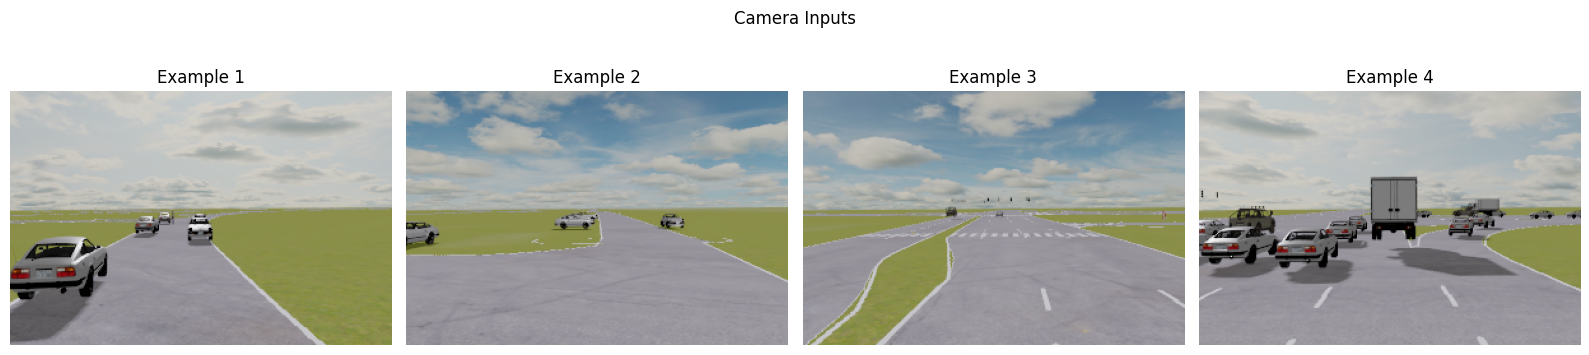

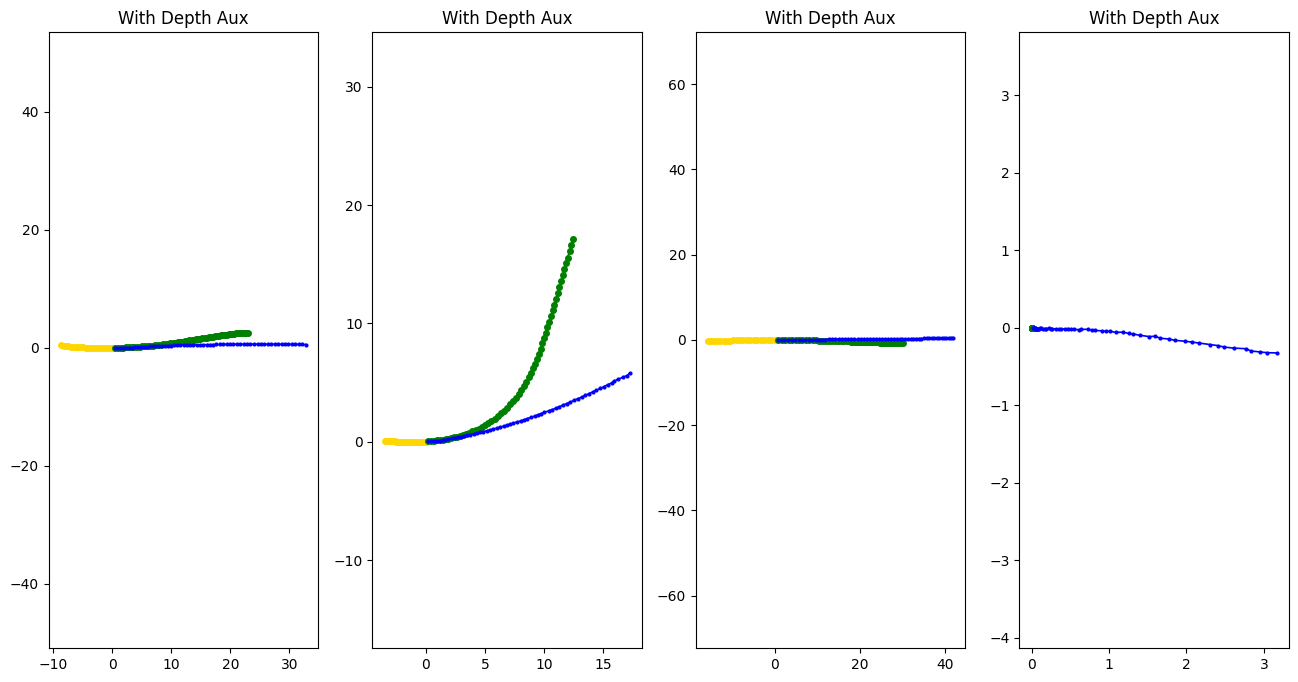

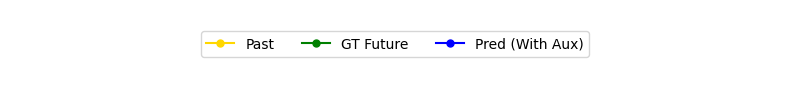

<Figure size 640x480 with 0 Axes>

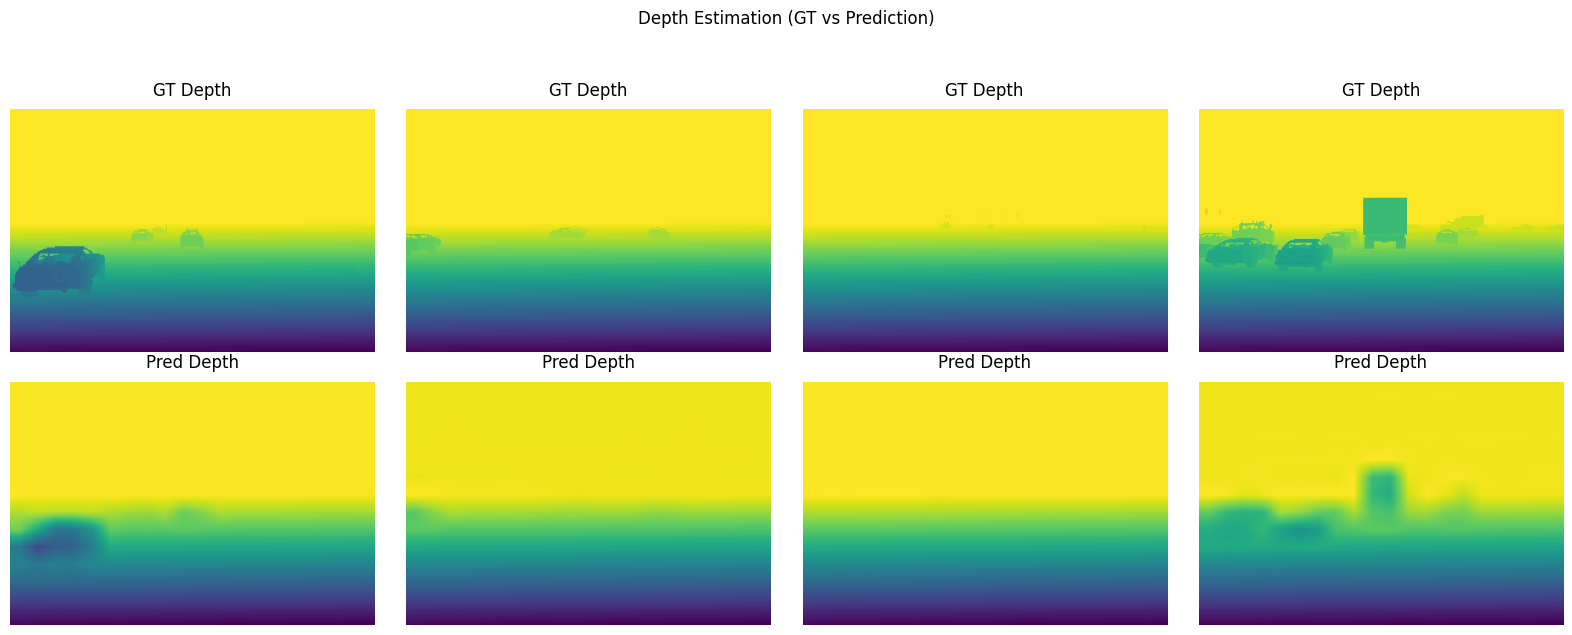

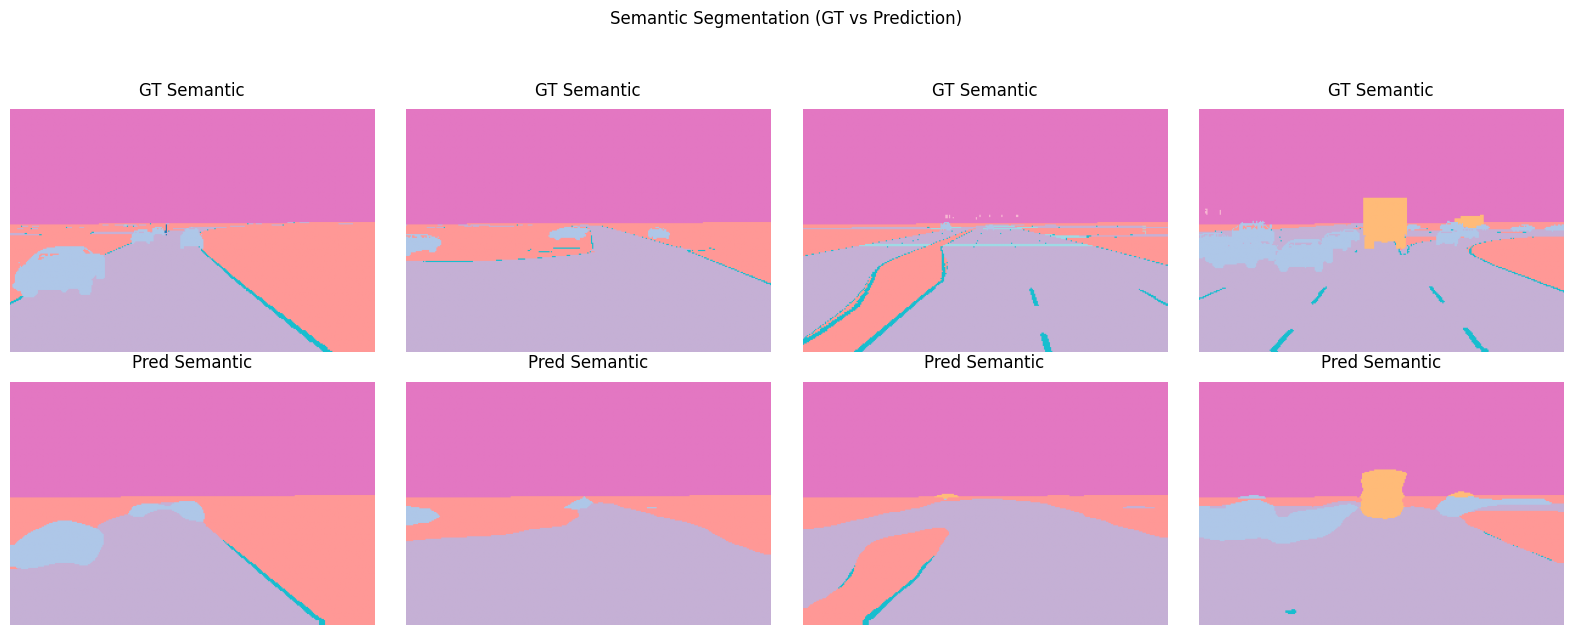

In [ ]:
# checkpoint = "version_19_epoch=95_val_ade=1.1653.ckpt"
# checkpoint_path = os.path.join("checkpoints", "phase2", "multitask_driving_planner_with_semantics", checkpoint)
# model = LightningDrivingPlanner.load_from_checkpoint(checkpoint_path)

# Call at the end after training 
model = model.to(torch.device('cuda' if torch.cuda.is_available() else 'cpu'))
future, pred_with_aux, depth, pred_depth = visualize_comparison(val_loader, model, device=torch.device('cuda' if torch.cuda.is_available() else 'cpu'))

## Save test predictions

In [74]:

test_data_dir = os.path.join("data", "phase2", "test_public")

with open(os.path.join(test_data_dir, "0.pkl"), "rb") as f:
    data = pickle.load(f)
print(data.keys())
# Note the absence of sdc_future_feature
device = "cuda"
import pandas as pd
test_files = [os.path.join(test_data_dir, fn) for fn in sorted([f for f in os.listdir(test_data_dir) if f.endswith(".pkl")], key=lambda fn: int(os.path.splitext(fn)[0]))]
test_dataset = DrivingDataset(test_files, test=True)
test_loader = DataLoader(test_dataset, batch_size=250)
model.eval()
all_plans = []
with torch.no_grad():
    for batch in test_loader:
        camera = batch['camera'].to(device)
        history = batch['history'].to(device)

        #pred_future, _ = model(camera, history)
        depth_pred, traj_pred, conf_pred, pred_future, semantic_pred_logits = model(camera, history)
        all_plans.append(pred_future.cpu().numpy()[..., :2])
all_plans = np.concatenate(all_plans, axis=0)

# Now save the plans as a csv file
pred_xy = all_plans[..., :2]  # shape: (total_samples, T, 2)

# Flatten to (total_samples, T*2)
total_samples, T, D = pred_xy.shape
pred_xy_flat = pred_xy.reshape(total_samples, T * D)

# Build a DataFrame with an ID column
ids = np.arange(total_samples)
df_xy = pd.DataFrame(pred_xy_flat)
df_xy.insert(0, "id", ids)

# Column names: id, x_1, y_1, x_2, y_2, ..., x_T, y_T
new_col_names = ["id"]
for t in range(1, T + 1):
    new_col_names.append(f"x_{t}")
    new_col_names.append(f"y_{t}")
df_xy.columns = new_col_names

# Save to CSV
df_xy.to_csv("submission_phase2_mask_sem_k_03_dep_k_03_aug_val.csv", index=False)

print(f"Shape of df_xy: {df_xy.shape}")

dict_keys(['camera', 'depth', 'driving_command', 'sdc_history_feature', 'semantic_label'])
Shape of df_xy: (1000, 121)
